#**AIM** 
    Detect anomalies in the historical stock price time series data with an LSTM autoencoder

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0


In [2]:
import pandas as pd
df = pd.read_csv('JNJ.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-09-04,2.937500,2.960938,2.929688,2.953125,1.327704,4188800
1,1985-09-05,2.953125,2.992188,2.945313,2.976563,1.338241,6176000
2,1985-09-06,2.992188,3.000000,2.976563,2.992188,1.345266,6606400
3,1985-09-09,2.992188,2.992188,2.945313,2.945313,1.324190,3150400
4,1985-09-10,2.953125,2.960938,2.867188,2.875000,1.292579,2841600


In [4]:
df = df[['Date', 'Close']]

In [5]:
df.dtypes

Date      object
Close    float64
dtype: object

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df['Date'].min(), df['Date'].max()

(Timestamp('1985-09-04 00:00:00'), Timestamp('2020-03-06 00:00:00'))

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Stock Price 1985-2020')
fig.show()

In [9]:
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']

In [10]:
train.tail()

,Date,Close
7054,2013-08-27,86.169998
7055,2013-08-28,86.529999
7056,2013-08-29,86.570000
7057,2013-08-30,86.410004
7058,2013-09-03,86.419998


In [11]:
train.head()

,Date,Close
0,1985-09-04,2.953125
1,1985-09-05,2.976563
2,1985-09-06,2.992188
3,1985-09-09,2.945313
4,1985-09-10,2.875000


In [12]:
train.shape,test.shape

((7059, 2), (1638, 2))

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#**Create sequences**

Convert input data into 3-D array combining TIME_STEPS. The shape of the array should be **[samples, TIME_STEPS, features]**, as required for LSTM network.

We want our network to have memory of 30 days, so we set TIME_STEPS=30.

In [14]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [15]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (7029, 30, 1)
Testing shape: (1608, 30, 1)


#**Build the Model**

We define the reconstruction LSTM Autoencoder architecture that expects input sequences with 30 time steps and one feature and outputs a sequence with 30 time steps and one feature.

    RepeatVector() repeats the inputs 30 times.

    Set return_sequences=True, so the output will still be a sequence.

    TimeDistributed(Dense(X_train.shape[2])) is added at the end to get the output, where X_train.shape[2] is the number of features in the input data.

In [16]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

#**Train The Model**

In [17]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
198/198 [==============================] - 2s 10ms/step - loss: 0.1356 - val_loss: 0.1852
Epoch 2/100
198/198 [==============================] - 1s 7ms/step - loss: 0.1009 - val_loss: 0.1241
Epoch 3/100
198/198 [==============================] - 1s 6ms/step - loss: 0.0715 - val_loss: 0.0366
Epoch 4/100
198/198 [==============================] - 1s 6ms/step - loss: 0.0625 - val_loss: 0.0251
Epoch 5/100
198/198 [==============================] - 1s 6ms/step - loss: 0.0651 - val_loss: 0.0422
Epoch 6/100
198/198 [==============================] - 1s 6ms/step - loss: 0.0697 - val_loss: 0.0382
Epoch 7/100
198/198 [==============================] - 1s 7ms/step - loss: 0.0744 - val_loss: 0.0533


In [18]:
import matplotlib.pyplot as plt

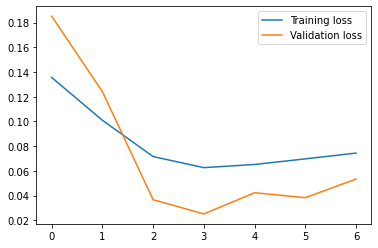

In [19]:


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();



In [20]:


model.evaluate(X_test, y_test)



51/51 [==============================] - 0s 3ms/step - loss: 0.2337


0.2337387204170227

#**Determine Anomalies**

Find MAE loss on the training data.
Make the max MAE loss value in the training data as the reconstruction error threshold.

If the reconstruction loss for a data point in the test set is greater than this reconstruction error threshold value then we will label this data point as an anomaly.

Reconstruction error threshold: 0.5844087218391423


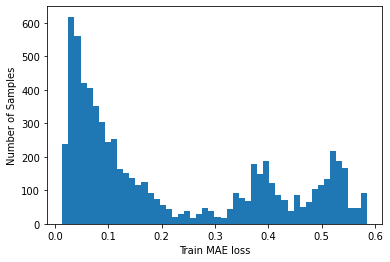

In [21]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

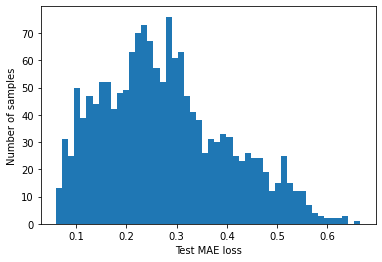

In [22]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [23]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

In [24]:


test_score_df.tail()



,Date,Close,loss,threshold,anomaly
8692,2020-03-02,4.139963,0.272717,0.584409,False
8693,2020-03-03,3.960813,0.256394,0.584409,False
8694,2020-03-04,4.279885,0.293607,0.584409,False
8695,2020-03-05,4.220438,0.218808,0.584409,False
8696,2020-03-06,4.221247,0.202785,0.584409,False


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [26]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
7948,2017-03-16,3.672476,0.594012,0.584409,True
7949,2017-03-17,3.656300,0.592622,0.584409,True
8100,2017-10-20,4.236210,0.614313,0.584409,True
8101,2017-10-23,4.285547,0.637138,0.584409,True
8102,2017-10-24,4.205476,0.665852,0.584409,True


In [27]:
anomalies.shape

(13, 5)

As you can see, there are 13 data points in the test set that exceeded the reconstruction error threshold.

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()